## Importing the neccesary libraries

In [1]:
# Set random seed
seed = 123
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#sns.set(style="whitegrid", context='talk')

## Reading and Loading Data

In [2]:
df = pd.read_csv('tourist_accommodation_reviews.csv',encoding='latin1')

## Exploring the dataset

In [3]:
# number of rows and columns
df.shape

(53644, 5)

In [4]:
# first five rows in data
df.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review
0,rn579778340,Reviewed 1 week ago,Kathu,Thong Dee The Kathu Brasserie,Just been for sunday roast lamb and beef truly...
1,rn576350875,Reviewed 3 weeks ago,Kathu,Thong Dee The Kathu Brasserie,"Quietly set off the main road, nice atmosphere..."
2,rn574921678,Reviewed 4 weeks ago,Kathu,Thong Dee The Kathu Brasserie,I made a reservation for a birthday two days i...
3,rn572905503,"Reviewed April 12, 2018",Kathu,Thong Dee The Kathu Brasserie,We visit here regularly and never fail to be i...
4,rn572364712,"Reviewed April 10, 2018",Kathu,Thong Dee The Kathu Brasserie,Visited this wonderful place on my travels and...


In [5]:
# checking for missing values
df.isnull().any().sum()

0

In [6]:
# basic information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53644 entries, 0 to 53643
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     53644 non-null  object
 1   Review Date            53644 non-null  object
 2   Location               53644 non-null  object
 3   Hotel/Restaurant name  53644 non-null  object
 4   Review                 53644 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [7]:
#Review count by location
Review_count_by_location = df['Location'].value_counts().to_frame().reset_index().rename(columns={'index':'Location','Location':'Number_of_Review_Entry'})

In [8]:
Review_count_by_location.head()

,Location,Number_of_Review_Entry
0,Patong,16403
1,Karon,5826
2,Kata Beach,5752
3,Rawai,3811
4,Choeng Thale,3378


In [9]:
#Hotel count by location
Hotel_count_by_location=df.groupby('Location')['Hotel/Restaurant name'].nunique().sort_values(ascending = False).to_frame().reset_index().rename(columns={'Hotel/Restaurant name':'Location','Hotel/Restaurant name':'Number_of_Hotel/Restaurant'})

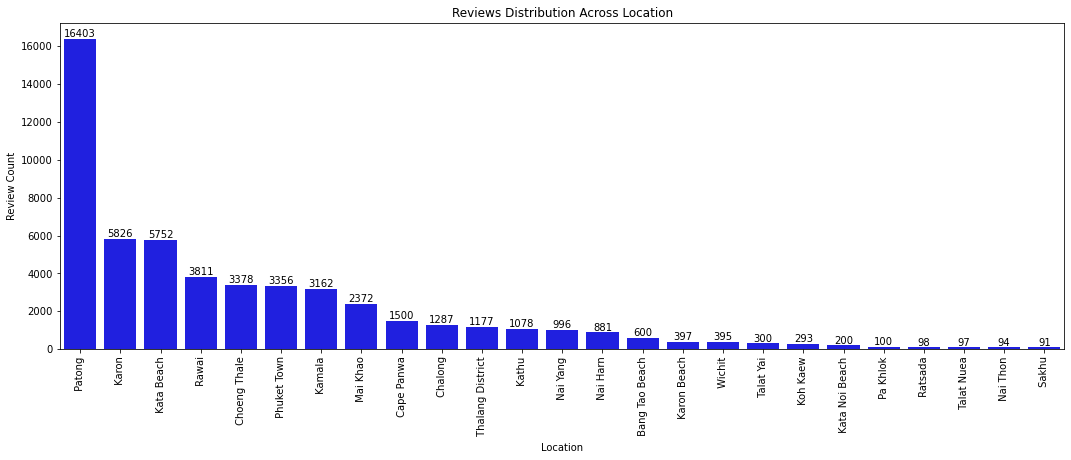

In [10]:
fig= plt.figure(figsize = (18, 6))

ax=sns.countplot(x = 'Location', data = df, color = 'blue', order = df['Location'].value_counts().index);
ax.bar_label(ax.containers[0])
plt.title('Reviews Distribution Across Location')
plt.xlabel('Location')
plt.ylabel('Review Count')
plt.xticks(rotation = 90);

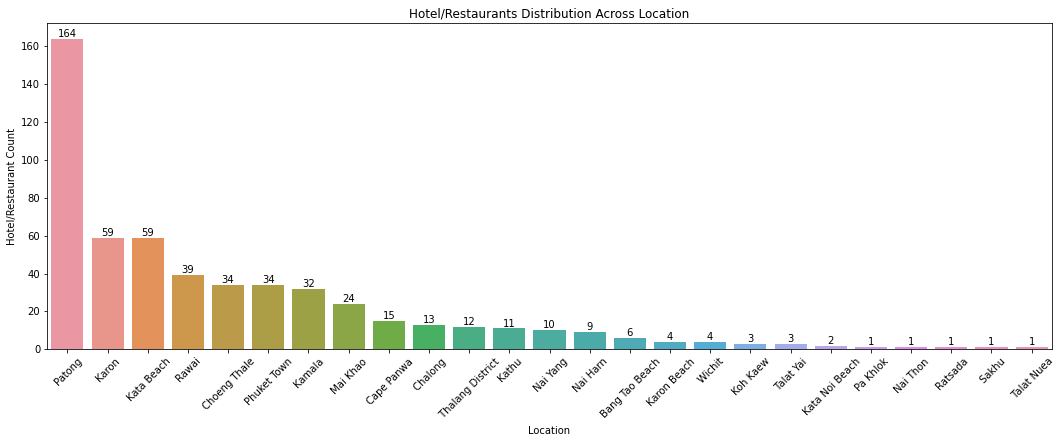

In [11]:
fig= plt.figure(figsize = (18, 6))

ax=sns.barplot(x = Hotel_count_by_location.Location.values, y = Hotel_count_by_location['Number_of_Hotel/Restaurant']);
ax.bar_label(ax.containers[0])
plt.title('Hotel/Restaurants Distribution Across Location')
plt.xlabel('Location')
plt.ylabel('Hotel/Restaurant Count')
plt.xticks(rotation = 45);

## Selection of 30 hotels by region for the sentiment analysis

In [12]:
regions = df['Location'].unique().tolist()

In [13]:
hotels_with_max_review_entry_per_region= []
for i in range(len(regions)):
    s = df[df['Location']== regions[i]]
    hotel_name = s.groupby('Hotel/Restaurant name')['ID'].count().sort_values(ascending = False).idxmax()
    max_count  = s.groupby('Hotel/Restaurant name')['ID'].count().sort_values(ascending = False).max()
    hotels_with_max_review_entry_per_region.append((hotel_name,max_count))
    


In [14]:
hotel_with_high_reviews =df.groupby('Hotel/Restaurant name')['ID'].count().sort_values(ascending = False).index[:6].tolist()

In [15]:
hotel_with_high_reviews

['Da Mario',
 'No.6 Restaurant',
 'Sabai Sabai',
 'The Pizza Company',
 'The Family Restaurant',
 'Outdoor Restaurant']

In [16]:
max_reviews = df.groupby('Hotel/Restaurant name')['ID'].count().sort_values(ascending = False)[:6].values.tolist()

In [17]:
hotel_max_reviews_multiple_region=[(hotel_with_high_reviews[i],max_reviews[j]) for i in range(len(hotel_with_high_reviews)) for j in range(len(max_reviews)) if i==j ]

In [18]:
hotel_max_reviews_multiple_region

[('Da Mario', 279),
 ('No.6 Restaurant', 200),
 ('Sabai Sabai', 200),
 ('The Pizza Company', 198),
 ('The Family Restaurant', 196),
 ('Outdoor Restaurant', 193)]

In [19]:
hotels_with_max_review_entry_per_region.extend(hotel_max_reviews_multiple_region)

In [20]:
selected_hotels_set=set(hotels_with_max_review_entry_per_region)

In [21]:
len(selected_hotels_set)

30

In [22]:
selected_hotels_reveiw_distribution=pd.DataFrame(selected_hotels_set,columns=['selected_hotels','review_counts']).reset_index(drop=True)

In [23]:
selected_hotels_reveiw_distribution

,selected_hotels,review_counts
0,Baan Ra Tree Restaurant,100
1,Bollywood Phuket Restaurant & Bar,100
2,No.6 Restaurant,200
3,Macarona - European Cuisine & Pizzeria,94
4,Amalfi,100
5,Baan Kalim,100
6,Baan Noy Restaurant,100
7,Outdoor Restaurant,193
8,The Pizza Company,198
9,Sabai Corner,100


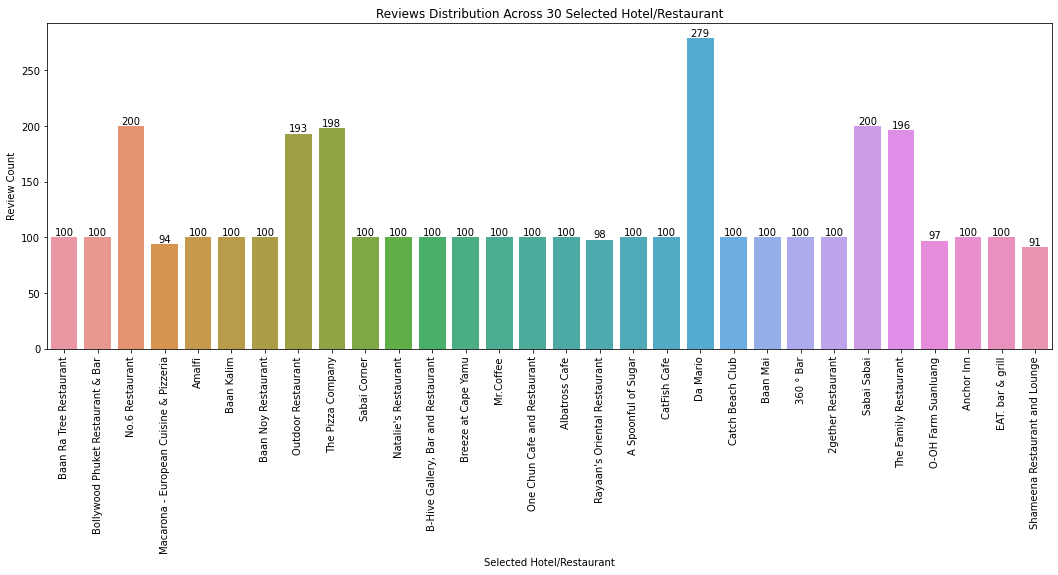

In [24]:
fig= plt.figure(figsize = (18, 6))

ax=sns.barplot(x = selected_hotels_reveiw_distribution.selected_hotels.values, y =selected_hotels_reveiw_distribution.review_counts.values);
ax.bar_label(ax.containers[0])
plt.title('Reviews Distribution Across 30 Selected Hotel/Restaurant')
plt.xlabel('Selected Hotel/Restaurant')
plt.ylabel('Review Count')
plt.xticks(rotation = 90);

In [25]:
selected_hotel=set(selected_hotels_reveiw_distribution.selected_hotels.values)

In [26]:
data = df[df['Hotel/Restaurant name'].apply(lambda x: x in selected_hotel)].reset_index(drop=True)

In [27]:
data.shape

(3646, 5)

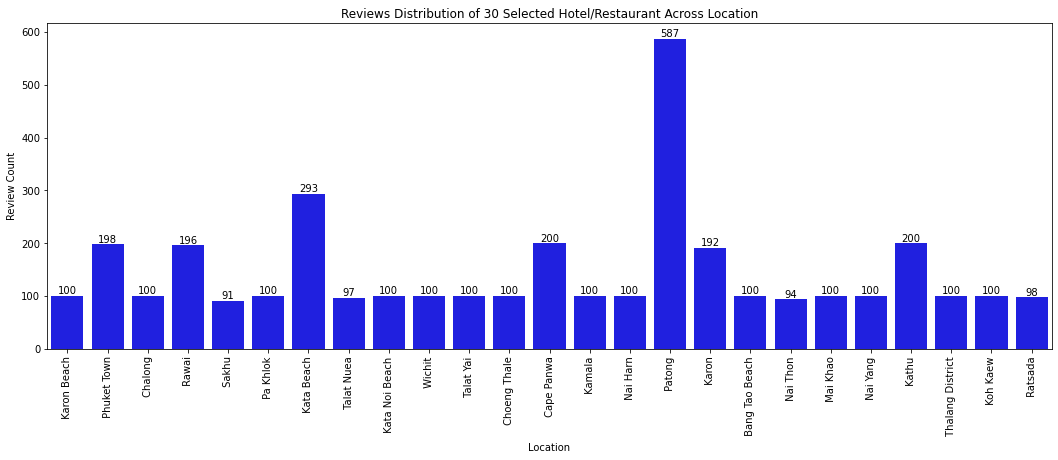

In [28]:
fig= plt.figure(figsize = (18, 6))
ax=sns.countplot(x = 'Location', data = data,color = 'blue',);
ax.bar_label(ax.containers[0])
plt.title('Reviews Distribution of 30 Selected Hotel/Restaurant Across Location')
plt.xlabel('Location')
plt.ylabel('Review Count')
plt.xticks(rotation = 90);

## Data Cleaning

In [29]:
data.drop(['Review Date'], axis=1,inplace = True)

In [30]:
data['Location'] = data['Location'].apply(lambda x: x.strip() if x.split(' ')[0] == '' or x.split(' ')[-1] == '' else x)

In [31]:
def remove_punctuations(x):
    x=x.translate(str.maketrans('', '', string.punctuation))
    return x

In [32]:
data.Review=data.Review.apply(lambda x:remove_punctuations(x))

In [33]:
data.Review=data.Review.map(lambda x: x.lower())

## Sentiment analysis

In [34]:
sid = SentimentIntensityAnalyzer()

In [35]:
data[['Negative', 'Neutral', 'Positive', 'Compound']] = data['Review'].apply(sid.polarity_scores).apply(pd.Series)

In [36]:
def get_Sentiment(df,col):
    val_list = df[col].tolist()
    sentiments = []
    for i in range(len(val_list)):
        if ((df.Positive[i] > df.Negative[i]) or (df.Positive[i]>df.Neutral[i])) and (df.Compound[i]>0.50):
            sentiments.append('positive')
        elif ((df.Negative[i] > df.Positive[i]) or (df.Negative[i]>df.Neutral[i])) and (df.Compound[i]<0.50):
            sentiments.append('negative')
        else:
            sentiments.append('neutral')
    df['Sentiment']=sentiments
    return df

In [37]:
data=get_Sentiment(data,'Review')

In [38]:
sentiment_dict = {'positive':1,'negative':0,'neutral':2}

In [39]:
data['Target']=data['Sentiment'].map(sentiment_dict)

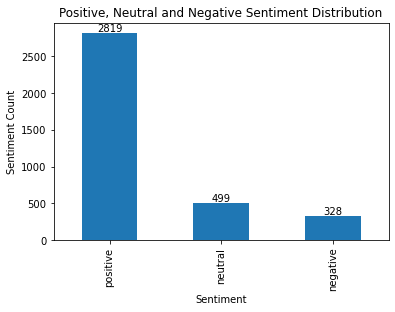

In [40]:
ax=data.Sentiment.value_counts().plot(kind='bar',title="Positive, Neutral and Negative Sentiment Distribution")
ax.bar_label(ax.containers[0])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Count')
plt.show()

In [41]:
#data with neutral sentiment
data_neutral=data[data.Sentiment == 'neutral']

In [42]:
#data with positive and negative sentiment
data_p_n=data[data.Sentiment != 'neutral']

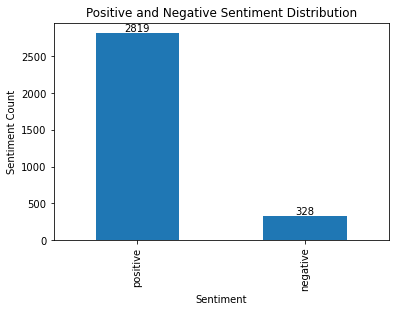

In [43]:
ax=data_p_n.Sentiment.value_counts().plot(kind='bar',title="Positive and Negative Sentiment Distribution")
ax.bar_label(ax.containers[0])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Count')
plt.show()

In [44]:
data_p_n['Vader_polarity'] = np.where(data_p_n['Positive']>data_p_n['Negative'], 1, 0)

C:\Users\User\AppData\Local\Temp\ipykernel_11900\3830250602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p_n['Vader_polarity'] = np.where(data_p_n['Positive']>data_p_n['Negative'], 1, 0)


In [45]:
target_names=['negative', 'positive']
print(classification_report(data_p_n['Target'],data_p_n['Vader_polarity'],
                             
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       328
    positive       1.00      1.00      1.00      2819

    accuracy                           1.00      3147
   macro avg       1.00      1.00      1.00      3147
weighted avg       1.00      1.00      1.00      3147



In [46]:
#confussion matrix plot function
def plot_cm(y_test, y_pred, target_names=['negative','positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

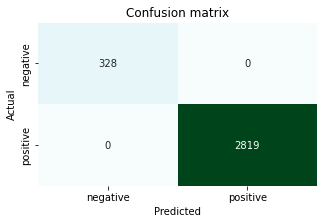

In [47]:
# Plot confusion matrix
plot_cm(data_p_n['Target'],data_p_n['Vader_polarity'])

In [48]:
data_p_n['Vader_compound'] = np.where(data_p_n['Compound']>0, 1, 0)

C:\Users\User\AppData\Local\Temp\ipykernel_11900\2445473429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p_n['Vader_compound'] = np.where(data_p_n['Compound']>0, 1, 0)


In [49]:
print(classification_report(data_p_n['Target'], 
                            data_p_n['Vader_compound'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       1.00      0.96      0.98       328
    positive       1.00      1.00      1.00      2819

    accuracy                           1.00      3147
   macro avg       1.00      0.98      0.99      3147
weighted avg       1.00      1.00      1.00      3147



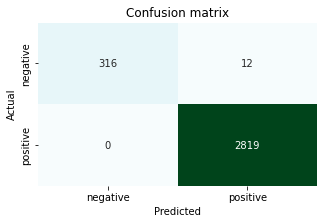

In [50]:
# Plot confusion matrix for 'Vader_compound
plot_cm(data_p_n['Target'], data_p_n['Vader_compound']) 

In [51]:
# adding 'polarity', 'subjectivity' from TextBlob to data
data_p_n[['polarity', 'subjectivity']] = data_p_n['Review'].apply(lambda x:TextBlob(x).sentiment).to_list()

C:\Users\User\AppData\Local\Temp\ipykernel_11900\2639362908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p_n[['polarity', 'subjectivity']] = data_p_n['Review'].apply(lambda x:TextBlob(x).sentiment).to_list()
C:\Users\User\AppData\Local\Temp\ipykernel_11900\2639362908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p_n[['polarity', 'subjectivity']] = data_p_n['Review'].apply(lambda x:TextBlob(x).sentiment).to_list()


In [52]:
data_p_n['blob_polarity'] = np.where(data_p_n['polarity']>0, 1, 0)
print(classification_report(data_p_n['Target'], 
                            data_p_n['blob_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.77      0.57      0.65       328
    positive       0.95      0.98      0.97      2819

    accuracy                           0.94      3147
   macro avg       0.86      0.77      0.81      3147
weighted avg       0.93      0.94      0.93      3147



C:\Users\User\AppData\Local\Temp\ipykernel_11900\1206430888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p_n['blob_polarity'] = np.where(data_p_n['polarity']>0, 1, 0)


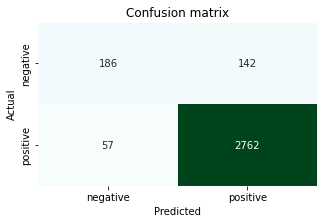

In [53]:
# Plot confusion matrix for 'blob_polarity'
plot_cm(data_p_n['Target'], data_p_n['blob_polarity'])

In [54]:
#crosstab of 'Vader_polarity' and 'blob_polarity'
pd.crosstab(data_p_n['Vader_polarity'], data_p_n['blob_polarity'])

blob_polarity,0,1
Vader_polarity,,
0,186,142
1,57,2762


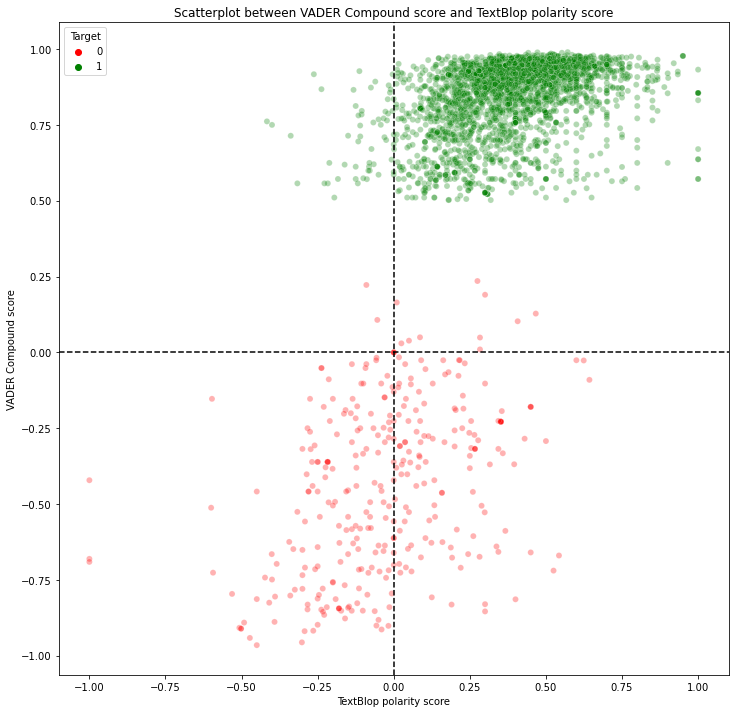

In [55]:
#camparison scatterplot between VADER Compound score and TextBlop polarity score
plt.figure(figsize=(12,12))
sns.scatterplot(data=data_p_n, x='polarity', y='Compound',
                hue='Target', palette=['red', 'green'], 
                alpha=.3)
plt.axhline(0, linestyle='--', color='k')
plt.axvline(0, linestyle='--', color='k')
plt.title('Scatterplot between VADER Compound score and TextBlop polarity score')
plt.xlabel('TextBlop polarity score')
plt.ylabel('VADER Compound score');

In [56]:
data_n=data_p_n[data_p_n['Sentiment']=='negative']
hotel_max_neg=data_n[data_n['Hotel/Restaurant name']=='Outdoor Restaurant']
region_max_neg=data_n[data_n['Location']=='Patong']

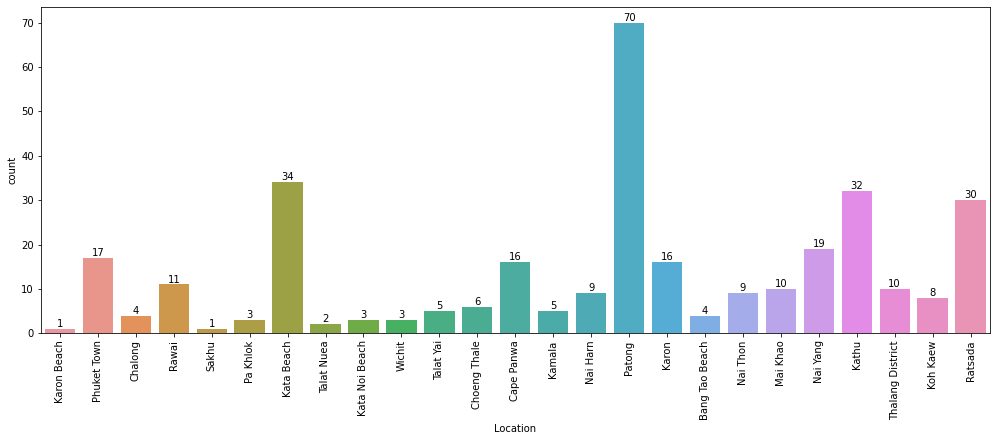

In [57]:
fig= plt.figure(figsize = (17, 6))
ax=sns.countplot(x=data_n['Location']) 
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90);

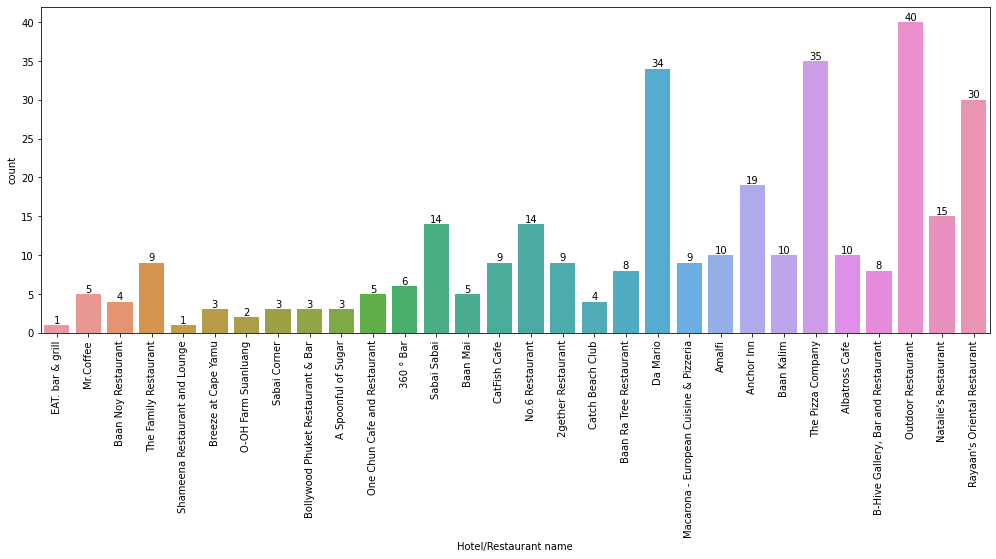

In [58]:
fig= plt.figure(figsize = (17, 6))
ax=sns.countplot(x=data_n['Hotel/Restaurant name']) 
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90);

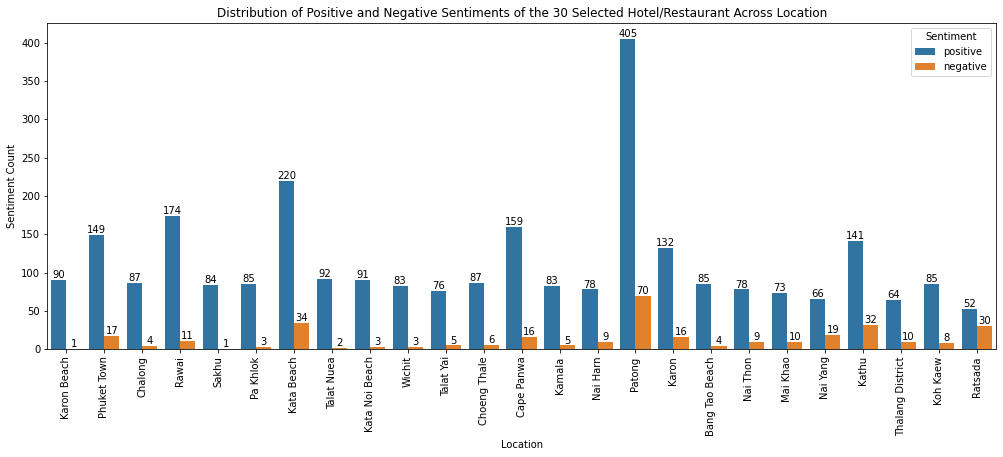

In [59]:
fig= plt.figure(figsize = (17, 6))
ax=sns.countplot(x=data_p_n['Location'],hue=data_p_n['Sentiment']) 
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Distribution of Positive and Negative Sentiments of the 30 Selected Hotel/Restaurant Across Location')
plt.xlabel('Location')
plt.ylabel('Sentiment Count')
plt.xticks(rotation = 90);

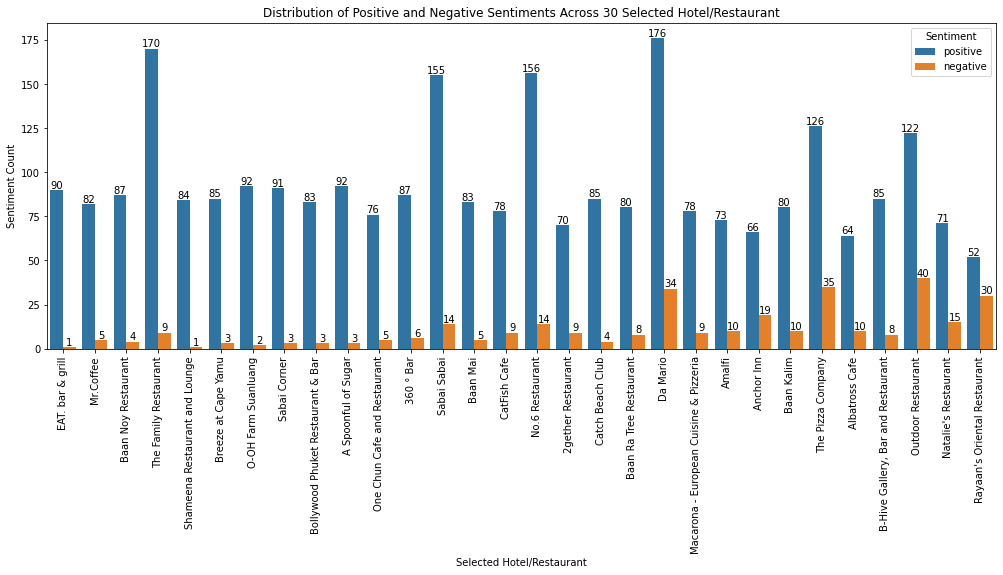

In [60]:
fig= plt.figure(figsize = (17, 6))
ax=sns.countplot(x=data_p_n['Hotel/Restaurant name'],hue=data_p_n['Sentiment']) 
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Distribution of Positive and Negative Sentiments Across 30 Selected Hotel/Restaurant')
plt.xlabel('Selected Hotel/Restaurant')
plt.ylabel('Sentiment Count')
plt.xticks(rotation = 90);

In [61]:
pos_sentiment=data_p_n[data_p_n['Sentiment']=='positive']

In [62]:
neg_sentiment=data_p_n[data_p_n['Sentiment']=='negative']

In [63]:
#positive
text_pos=' '
for i in range(len(pos_sentiment['Review'])):
    ps=pos_sentiment['Review'].values[i]
    text_pos+=ps

In [64]:
#negative
text_neg=' '
for i in range(len(neg_sentiment['Review'])):
    ng=neg_sentiment['Review'].values[i]
    text_neg+=ng

In [65]:
#neutral
text_neu=' '
for i in range(len(data_neutral['Review'])):
    nu=data_neutral['Review'].values[i]
    text_neu+=nu

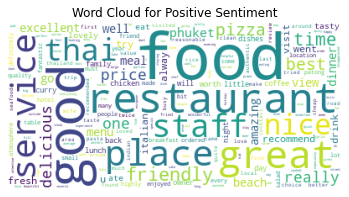

In [66]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_pos)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

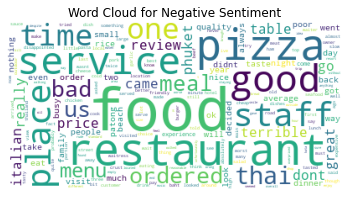

In [67]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neg)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

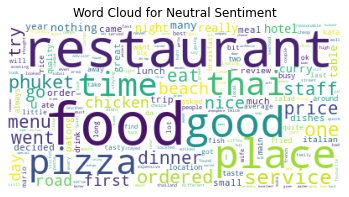

In [68]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neu)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment')
plt.show()

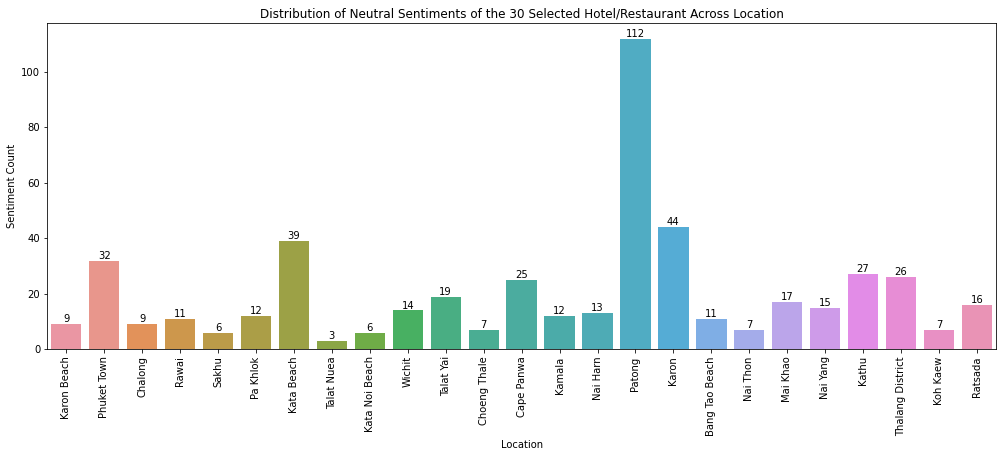

In [69]:
fig= plt.figure(figsize = (17, 6))
ax=sns.countplot(x=data_neutral['Location'])
ax.bar_label(ax.containers[0])
plt.title('Distribution of Neutral Sentiments of the 30 Selected Hotel/Restaurant Across Location')
plt.xlabel('Location')
plt.ylabel('Sentiment Count')
plt.xticks(rotation = 90);

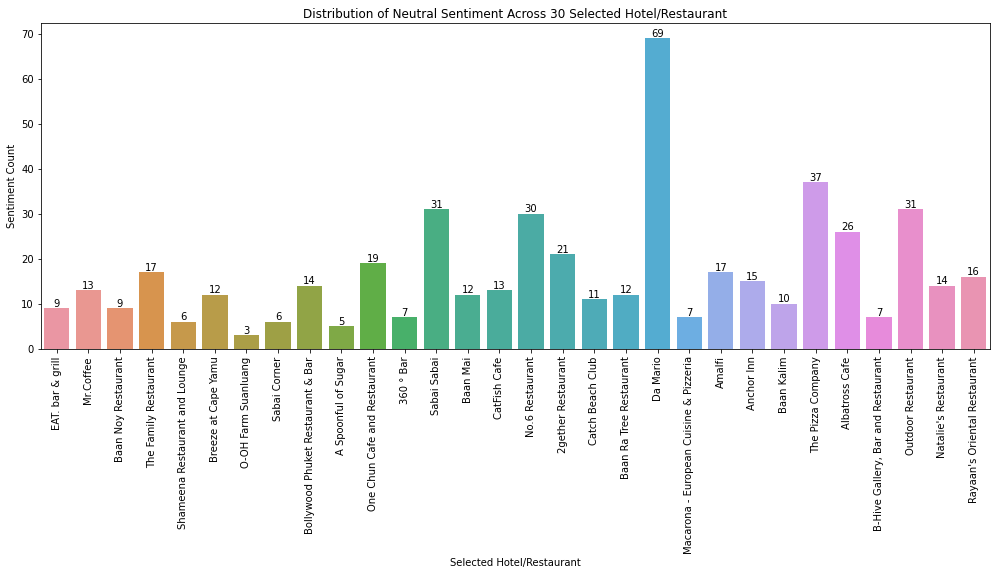

In [70]:
fig= plt.figure(figsize = (17, 6))
ax=sns.countplot(x=data_neutral['Hotel/Restaurant name']) 
ax.bar_label(ax.containers[0])
plt.title('Distribution of Neutral Sentiment Across 30 Selected Hotel/Restaurant')
plt.xlabel('Selected Hotel/Restaurant')
plt.ylabel('Sentiment Count')
plt.xticks(rotation = 90);

## Model Training

In [71]:
X= data_p_n.Review
Y= data_p_n.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

In [72]:
print('X_train :', len(X_train))
print('X_test :', len(X_test))
print('y_train :', len(y_train))
print('y_test :', len(y_test))

X_train : 2517
X_test : 630
y_train : 2517
y_test : 630


In [73]:
tvec= TfidfVectorizer()
rf = RandomForestClassifier(random_state = 10)

In [74]:
model = Pipeline([('vectorizer',tvec),('classifier',rf)])

In [75]:
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier(random_state=10))])

In [76]:
predictions=model.predict(X_test)

In [77]:
confusion_matrix(predictions,y_test)

array([[  8,   0],
       [ 64, 558]], dtype=int64)

In [78]:
print(classification_report(y_test, 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       1.00      0.11      0.20        72
    positive       0.90      1.00      0.95       558

    accuracy                           0.90       630
   macro avg       0.95      0.56      0.57       630
weighted avg       0.91      0.90      0.86       630



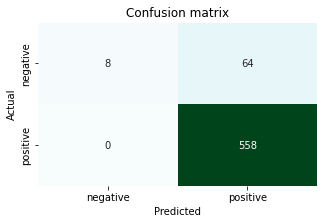

In [79]:
plot_cm(y_test, predictions)